In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

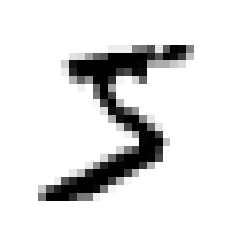

In [7]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

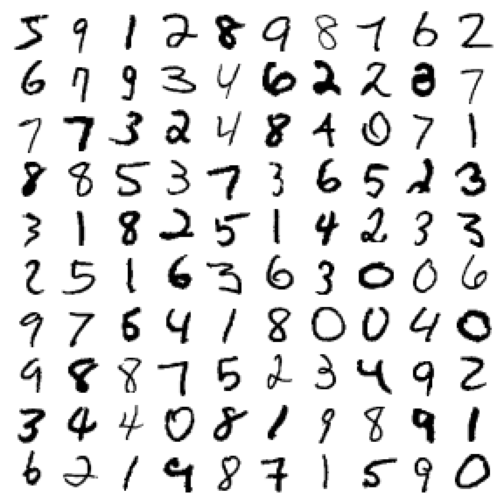

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9633 , 0.95695, 0.9146 ])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/Tom/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9633
0.95695
0.9146


In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [21]:
# Next we will look at the confusion matrix
# To have a confusion matrix we first need to have a set of predictions to be compared to actuals
# You could do predictions on the test set but you would ideally keep this for only at the very end of your project
# So instead you can use cross validation to have train and test splits on the training data

# The below will return the predictions made on each of the k test folds
# So the prediction is made by a model that never saw that data in training

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# Each row is an 'actual' class
# Each column is a 'predicted' class

array([[52336,  2243],
       [ 1060,  4361]])

In [23]:
# Lets assume that we reach perforection in our modelling such that
y_train_perfection = y_train_5
confusion_matrix(y_train_5, y_train_perfection)

array([[54579,     0],
       [    0,  5421]])

In [27]:
# We can then move on to look at precision and recall
# Precision = How accurate are the positive predictions (TP/TP+FP)
# Recall = Is the positive actual instances that are correctly detected (TP/TP+FN)

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

# Of the things it predicts as a 5, only 66% are correct

0.6603573591762568

In [29]:
recall_score(y_train_5, y_train_pred)

# Of the true instancces of a 5, only 80% are actually detected

0.8044641210108836

In [33]:
# As precision and recall are often looked at in conjunction with eachother it is convenient to produce a combined metric
# This is the F1 score, it is the harmonic mean of precision and recall
# F1 = 2 * (Precision * Recall)/(Precision + Recall)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

# The F1 score favours classifiers with a similar precision and recall
# This is not always ideal, i.e. it may be more important to have a high recall

0.7253222453222454

In [34]:
# To look at the decisions a SGD Classifier made you can call the decision_function()

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([57392.7316778])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
# To decide what threshold to use for the classifier lets look at the decision scores

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
# We now have the decision scores
# With the scores you compute precision and recall for all thresholds
# This is done using the precision_recall_curve()

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

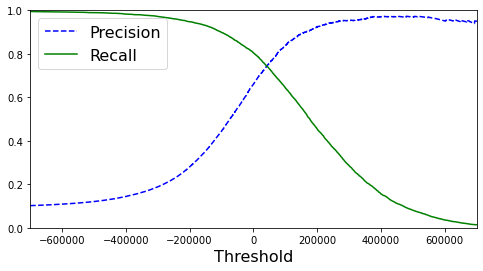

In [39]:
# Now we can plot the precision and recall as a function of the threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize = (8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [40]:
# If we aim for 90% precision we can search for the lowest threshold that gives us this

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

163633.30315197553

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9002517306482064

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.5277624054602472

In [43]:
# You can see that by upping the precision to 90% has lead to a reduction in the recall of the classifier

In [44]:
# Instead of precision and recall we can look at the ROC curve
# ROC stands for receiver operating characteristic
# The ROC curve plots the true positive rate against the false positive rate

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

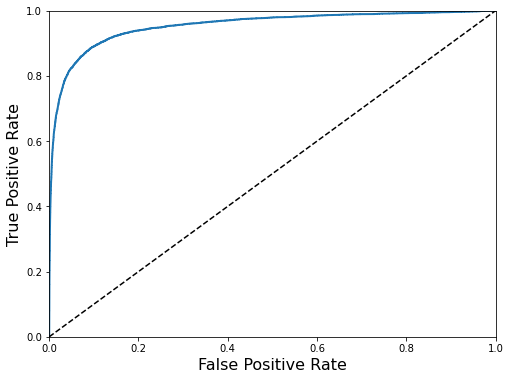

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # A dashed diagonal line
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.axis([0,1,0,1])
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()